In [118]:
from pathlib import Path
import pandas as pd
import numpy as np
import autosklearn.regression
import sklearn
import matplotlib.pyplot as plt
import joblib
import math
import time
from IPython.display import display
from nextorch import plotting, bo, doe, io

In [119]:
# Train the flow reaction model for yield and selectivity prediction from scratch
DATA_PATH = Path("../data/moo")
TRAIN = DATA_PATH / "train.csv"
TEST = DATA_PATH / "test.csv"
dataset_name = "flow"

def load_data(path: Path) -> tuple:
    df = pd.read_csv(path)
    X = df.drop(["yield", "selectivity"], axis=1).to_numpy()
    y = df[["yield", "selectivity"]].to_numpy()
    return df, X, y

df_train, X_train, y_train = load_data(TRAIN)
df_test, X_test, y_test = load_data(TEST)

In [120]:
# Inspect the input data
df = pd.concat([df_train, df_test])
print(len(df))
df.head()

29


,m_B,t_RT1,T_drawH,m_C,t_RT2,T_methyl,yield,selectivity
0,2.66,8.45,-39.0,3.15,121.20,-30,54.65,90.57
1,2.65,4.23,-39.0,3.15,121.20,-30,74.50,86.99
2,2.66,2.07,-39.0,3.15,121.20,-30,72.93,84.90
3,3.13,3.70,-39.0,3.15,121.20,-30,71.73,80.67
4,2.07,9.14,-34.0,0.71,8.64,-35,24.49,52.03


In [121]:
# Set the operating range for each parameter
X_ranges = []
# Set the reponse range
Y_plot_range = []

for column in df.columns:
    num = len(df)
    max_value = df[column].max()
    min_value = df[column].min()
    data_range = max_value - min_value
    print(f"ColName: {column}")
    print(f"Max value: {max_value}, Recommendation: {math.ceil(max_value)}")
    print(f"Min value: {min_value}, Recommendation: {math.floor(min_value)}")
    print(f"Range: {data_range}, Recommendation: {data_range / num}")
    print("------------------------")
    # Excludes traget
    if column == "yield" or column == "impurity":
        Y_plot_range.extend([0, 100])
    else:
        X_ranges.append([min_value, max_value])

ColName: m_B
Max value: 3.13, Recommendation: 4
Min value: 2.07, Recommendation: 2
Range: 1.06, Recommendation: 0.036551724137931035
------------------------
ColName: t_RT1
Max value: 36.57, Recommendation: 37
Min value: 2.07, Recommendation: 2
Range: 34.5, Recommendation: 1.1896551724137931
------------------------
ColName: T_drawH
Max value: -17.3, Recommendation: -17
Min value: -49.0, Recommendation: -49
Range: 31.7, Recommendation: 1.0931034482758621
------------------------
ColName: m_C
Max value: 3.15, Recommendation: 4
Min value: 0.71, Recommendation: 0
Range: 2.44, Recommendation: 0.08413793103448276
------------------------
ColName: t_RT2
Max value: 278.6, Recommendation: 279
Min value: 3.85, Recommendation: 3
Range: 274.75, Recommendation: 9.474137931034482
------------------------
ColName: T_methyl
Max value: -12, Recommendation: -12
Min value: -41, Recommendation: -41
Range: 29, Recommendation: 1.0
------------------------
ColName: yield
Max value: 83.42, Recommendation: 84

In [122]:
# Auto-sklearn model
model_path = Path("../model/autosklearn/")
model_path.mkdir(exist_ok=True, parents=True)

rerun = False

if rerun:
    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
    )
    automl.fit(X_train, y_train, dataset_name=dataset_name)
    joblib.dump(automl, model_path / "auto-sklearn_reg_moo.pkl")
else:
    automl = joblib.load(model_path / "auto-sklearn_reg_moo.pkl")
    print(automl.predict(X_train))  # Print some prediction for X_train

Fitting to the training data:   0%|          | 0/120 [00:00<?, ?it/s, The total time budget for this task is 0:02:00]

[WARNING] [2024-01-21 22:53:14,292:Client-AutoMLSMBO(1)::flow] Could not find meta-data directory /home/sun/zsl/tools/auto-sklearn/auto-sklearn/autosklearn/metalearning/files/r2_multioutput.regression_dense


Fitting to the training data: 100%|██████████| 120/120 [01:48<00:00,  1.10it/s, The total time budget for this task is 0:02:00]


          rank  ensemble_weight           type      cost  duration
model_id                                                          
58           1             0.72  random_forest  0.384305  0.682406
46           2             0.28  decision_tree  0.388779  0.346644
Train R2 score: 0.9087940925423972
Test R2 score: 0.8015575485748663


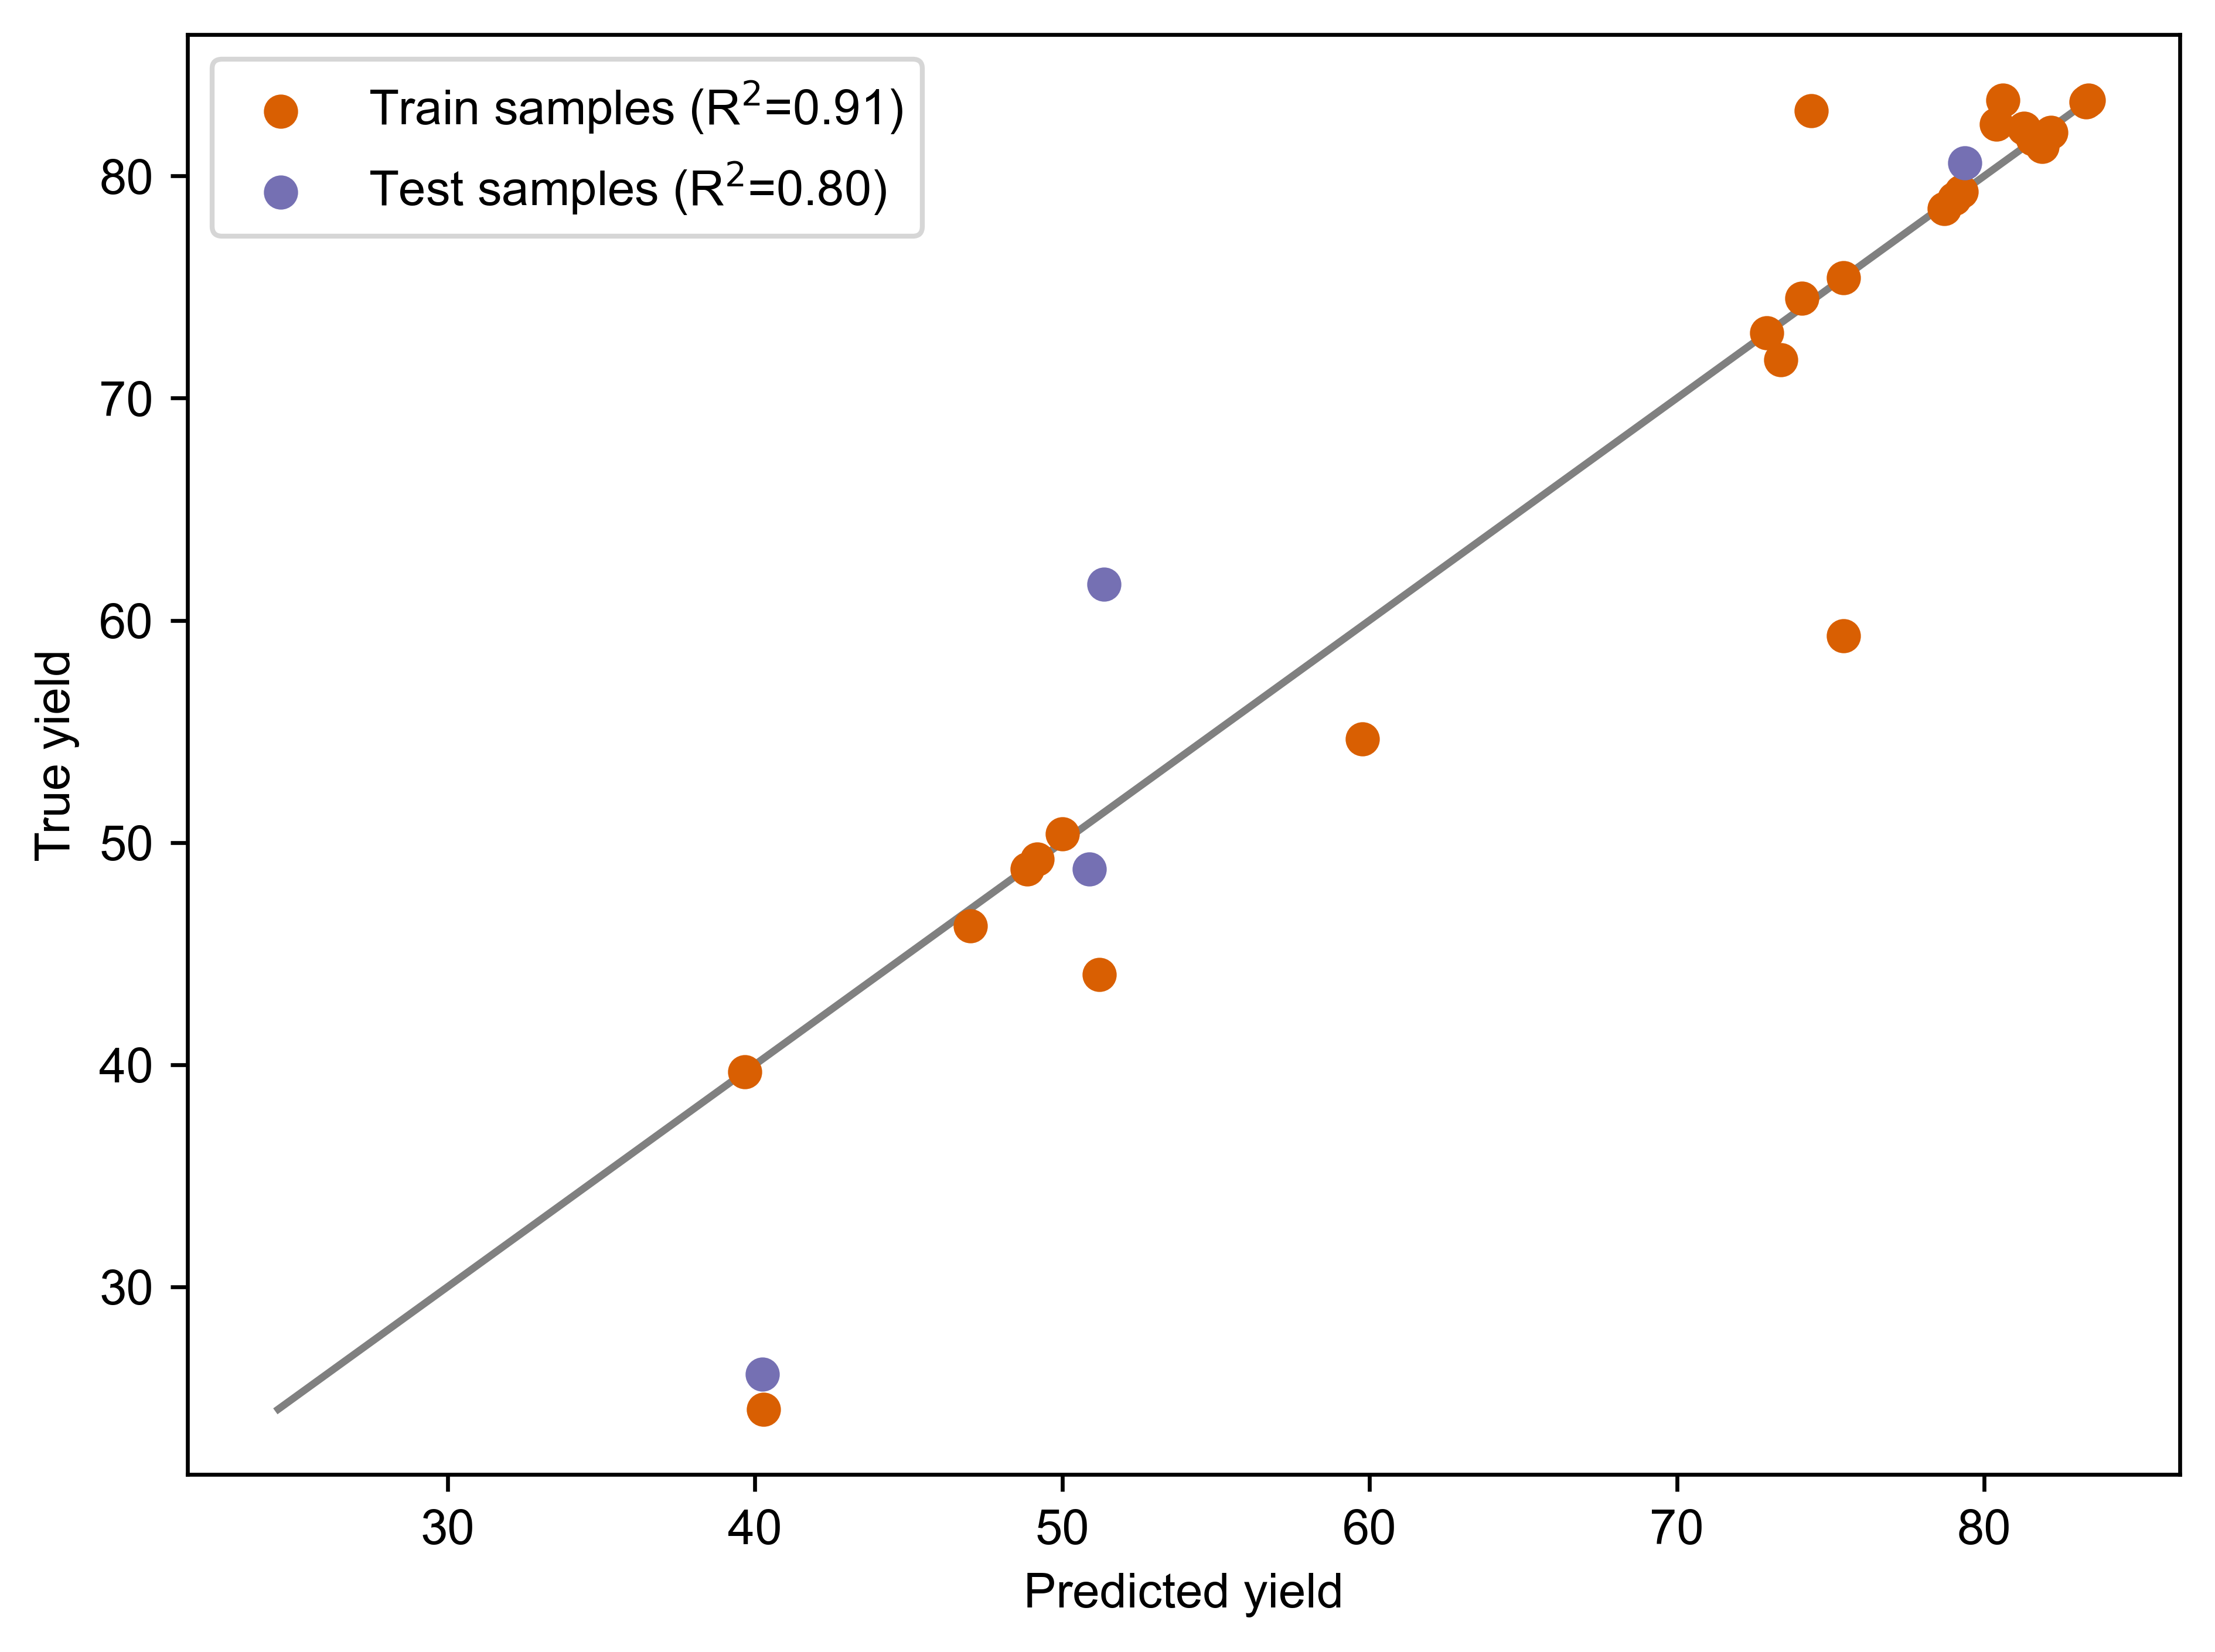

Train R2 score: 0.5839903654798497
Test R2 score: 0.6312378854188047


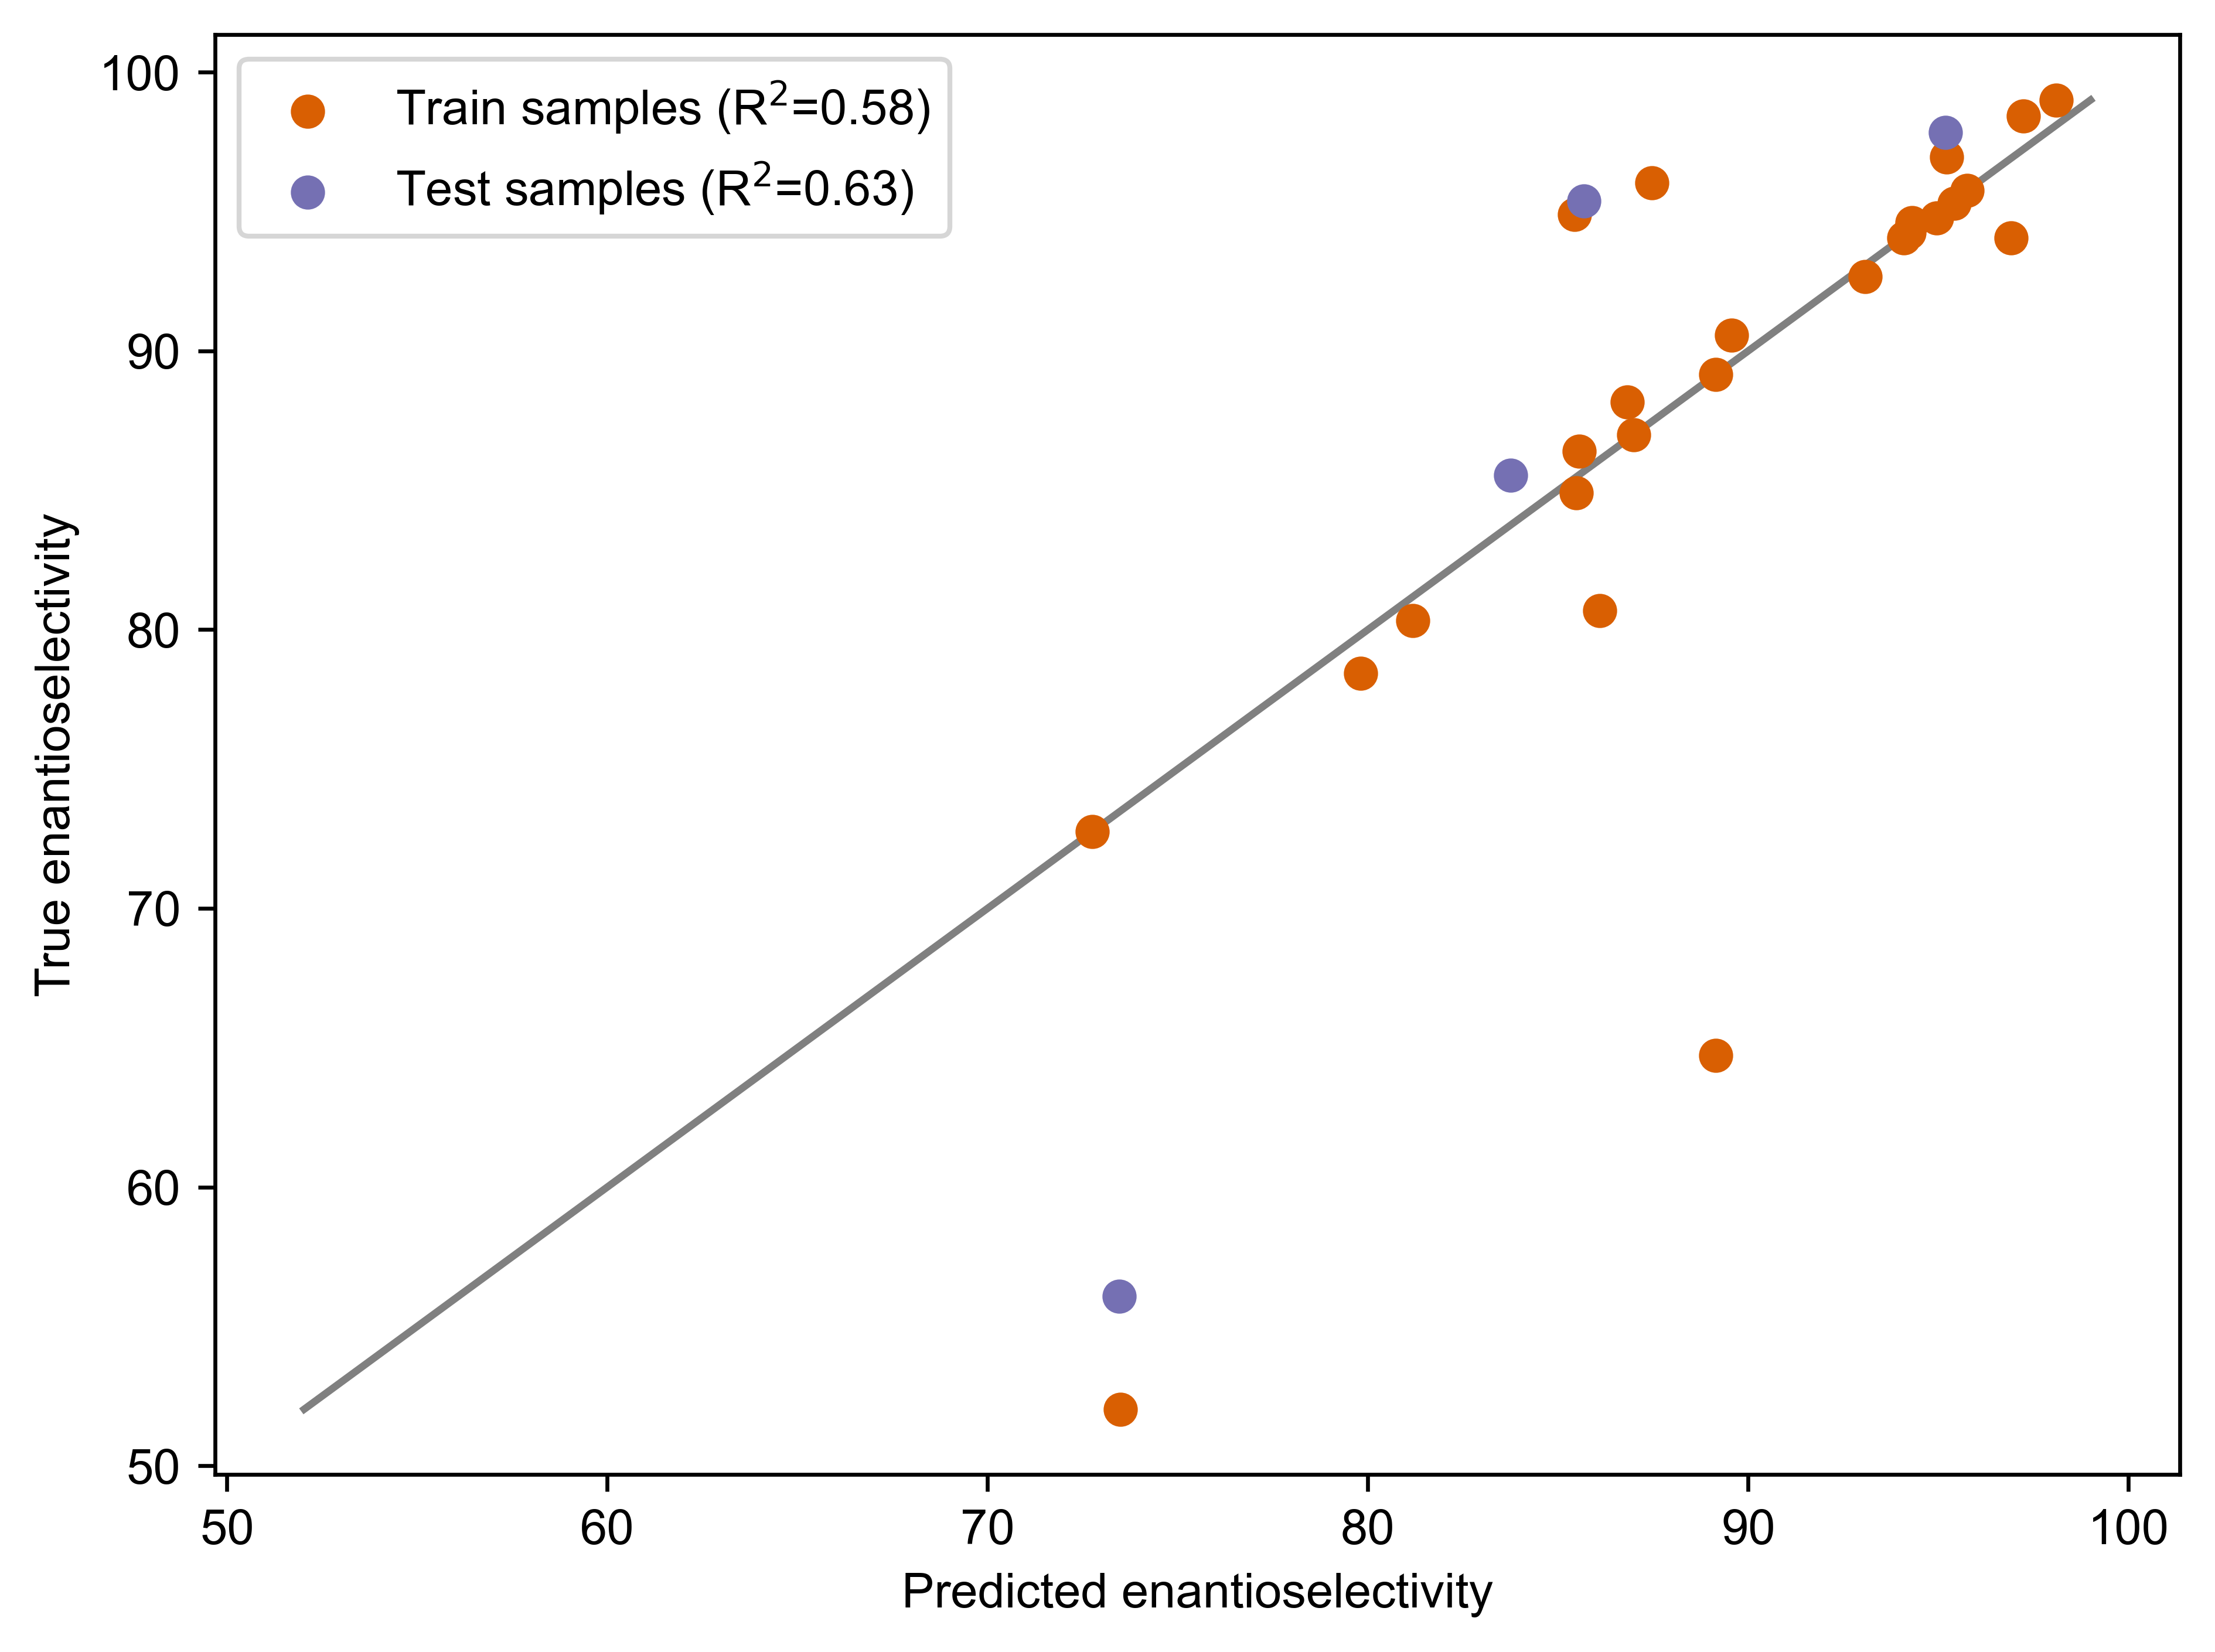

In [123]:
print(automl.leaderboard())

_train_predictions = automl.predict(X_train)
_test_predictions = automl.predict(X_test)

_y_train = y_train
_y_test = y_test

# Plotting
plt.rcParams["font.family"] = "arial"
plt.rcParams['figure.dpi'] = 600

# Get the score of final ensemble
# Yield
i = 0
train_predictions = _train_predictions[:, i]
test_predictions = _test_predictions[:, i]
y_train = _y_train[:, i]
y_test = _y_test[:, i]

train_r2 = sklearn.metrics.r2_score(y_train, train_predictions)
test_r2 = sklearn.metrics.r2_score(y_test, test_predictions)

print("Train R2 score:", train_r2)
print("Test R2 score:", test_r2)
plt.scatter(train_predictions, y_train, label=f"Train samples (R$^2$={train_r2:.2f})", c="#d95f02")
plt.scatter(test_predictions, y_test, label=f"Test samples (R$^2$={test_r2:.2f})", c="#7570b3")
plt.xlabel("Predicted yield")
plt.ylabel("True yield")
plt.legend()
plt.plot(c="k", zorder=0)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         c="grey", zorder=0)
plt.tight_layout()
plt.show()

# Selectivity
i = 1
train_predictions = _train_predictions[:, i]
test_predictions = _test_predictions[:, i]
y_train = _y_train[:, i]
y_test = _y_test[:, i]

train_r2 = sklearn.metrics.r2_score(y_train, train_predictions)
test_r2 = sklearn.metrics.r2_score(y_test, test_predictions)

print("Train R2 score:", train_r2)
print("Test R2 score:", test_r2)
plt.scatter(train_predictions, y_train, label=f"Train samples (R$^2$={train_r2:.2f})", c="#d95f02")
plt.scatter(test_predictions, y_test, label=f"Test samples (R$^2$={test_r2:.2f})", c="#7570b3")
plt.xlabel("Predicted enantioselectivity")
plt.ylabel("True enantioselectivity")
plt.legend()
plt.plot(c="k", zorder=0)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         c="grey", zorder=0)
plt.tight_layout()
plt.show()

# restore
y_train = _y_train
y_test = _y_test

In [124]:
# Define the objective function
def Reactor(X_real):
    Y_real = automl.predict(X_real)
    return Y_real  # yield and selectivity

In [125]:
# Objective function
objective_func = Reactor

# Define the design space
# Three input temperature C, pH, log10(residence time)
x_name_simple = df.columns[:-2]
X_name_list = x_name_simple
X_units = ["" for i in range(len(x_name_simple))]

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i] == "":
        var = var + " (" + X_units[i] + ")"
    X_name_with_unit.append(var)

# two outputs
Y_name_with_unit = ["Yield(%)", "Enantioselectivity(%)"]

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Get the information of the design space
n_dim = len(X_name_list)  # the dimension of inputs
n_objective = len(Y_name_with_unit)  # the dimension of outputs

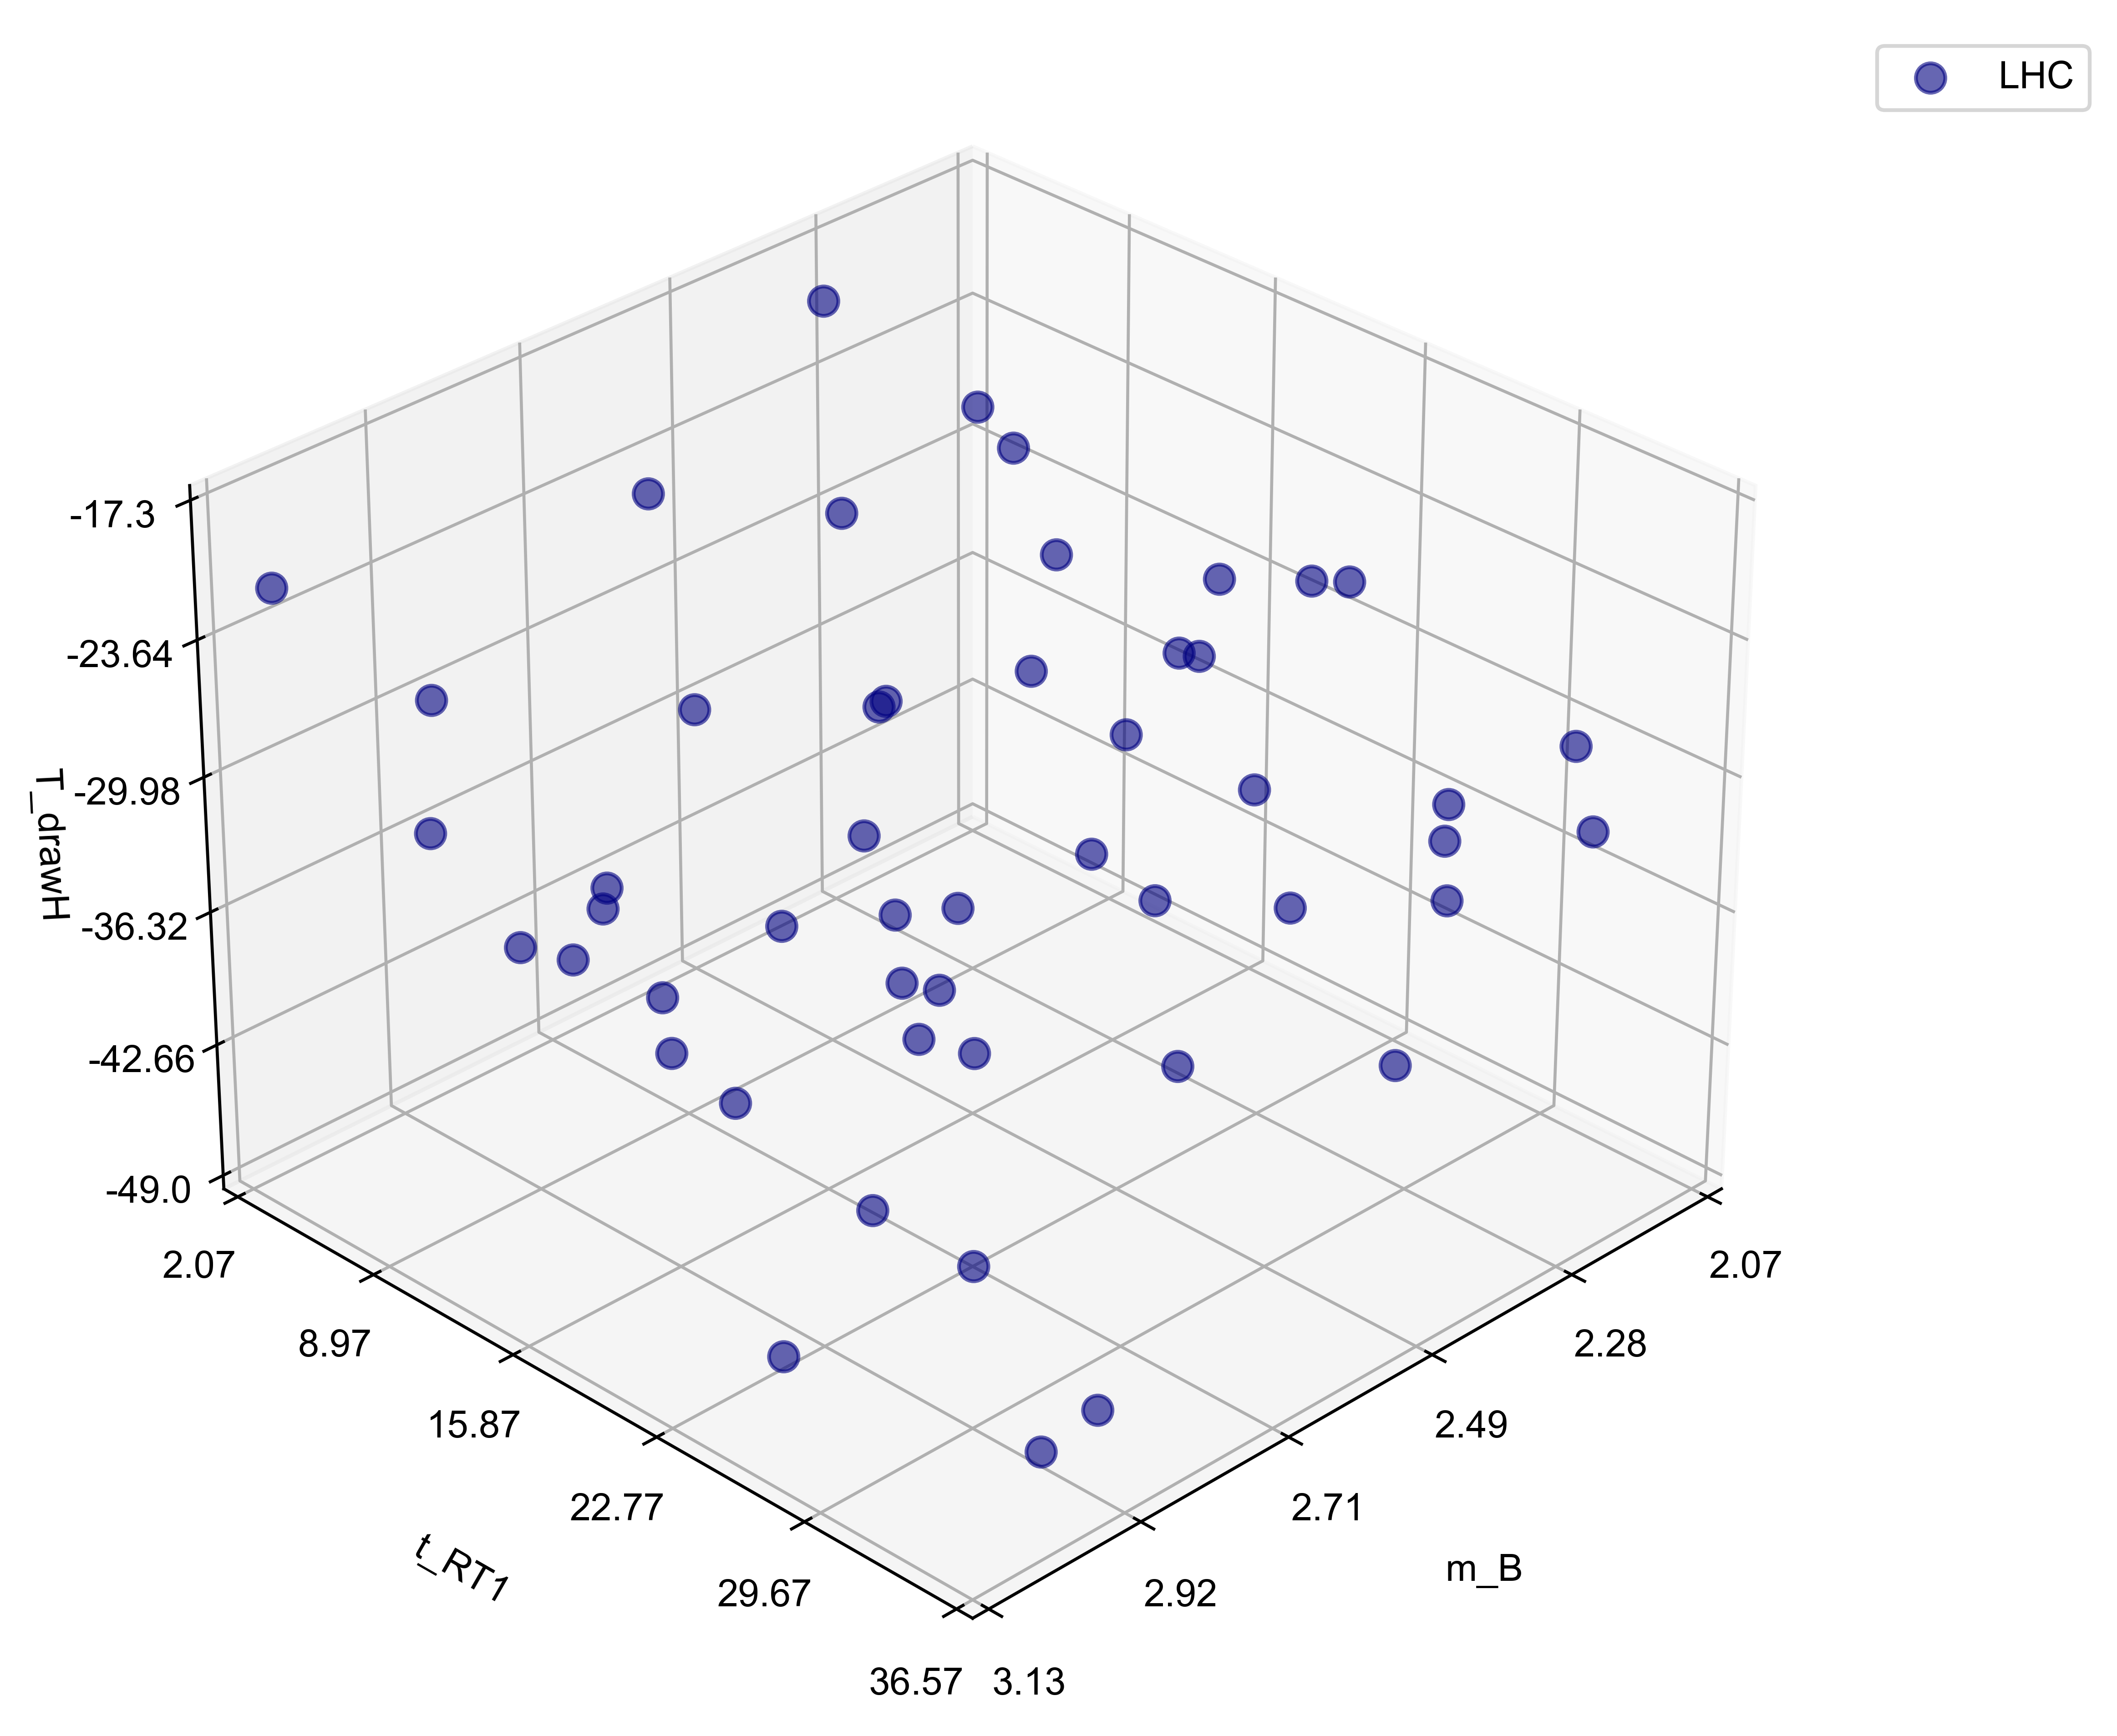

In [126]:
# Initial Sampling
# Latin hypercube design with 10 initial points
n_init_lhc = 50
X_init_lhc = doe.latin_hypercube(n_dim=n_dim, n_points=n_init_lhc, seed=5)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(
    X_init_lhc, X_names=X_name_with_unit, X_ranges=X_ranges, design_names="LHC"
)

In [127]:
# Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.WeightedMOOExperiment("yield_MOO")
# Import the initial data
Exp_lhc.input_data(
    X_init_lhc,
    Y_init_lhc,
    X_ranges=X_ranges,
    X_names=X_name_with_unit,
    Y_names=Y_name_with_unit,
    unit_flag=True,
)

# Set the optimization specifications
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 40  # number of single Experiments

# Set a weight vector for objective 1
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(
    objective_func=objective_func, maximize=True, weights=weights_obj_1
)
end_time = time.time()
print(
    "Initializing {} Experiments takes {:.2f} minutes.".format(
        n_exp, (end_time - start_time) / 60
    )
)

Initializing 40 experiments
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 2.50 % 


Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 5.00 % 
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 7.50 % 
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 10.00 % 
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 12.50 % 
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 15.00 % 
Iter 10/100: 3.1957077980041504
Iter 20/100: 2.9732089042663574
Iter 30/100: 2.6153786182403564
Iter 40/100: 2.190011501312256
Initializing experiments 17.50 % 
Iter 10/100: 3.1957077980041504
Iter

In [128]:
# Set the number of iterations for each experiments
n_trials_lhc = 50
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print(
    "Optimizing {} Experiments takes {:.2f} minutes.".format(
        n_exp, (end_time - start_time) / 60
    )
)

Running 40 experiments


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.197174310684204


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.199981689453125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.117006778717041


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1303694248199463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0824010372161865


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0458834171295166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.019937753677368


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.981706142425537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9504629373550415


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9134972095489502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8813269138336182


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.840397596359253


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8154559135437012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7939517498016357


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7659087181091309


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.740349292755127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7099394798278809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6656532287597656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6206601858139038


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6158785820007324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5511462688446045


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.52748441696167


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.400980830192566
Iter 20/100: 1.3010997772216797
Iter 30/100: 1.2673754692077637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3830724954605103


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3429391384124756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1424437761306763
Iter 20/100: 1.14375638961792


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0682530403137207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5269355773925781


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5986335277557373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5517587661743164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4340691566467285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4885966777801514


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3807814121246338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5092185735702515


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.451898217201233


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4245126247406006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4030038118362427


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3847224712371826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3533155918121338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3080878257751465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2534558773040771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9476848840713501


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9385426044464111


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.920678436756134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8931863307952881


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8809887170791626


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8678022623062134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8690130710601807


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8567302227020264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8397930860519409
Running experiments 2.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.197755813598633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.200185775756836


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.117506265640259


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1302151679992676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0832953453063965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0455679893493652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0153143405914307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9754891395568848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9489251375198364


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9073007106781006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8841664791107178


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8620357513427734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.828290581703186


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7888548374176025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.782393455505371


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6330599784851074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7909878492355347


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7126085758209229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6363517045974731


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.629157543182373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6343331336975098


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5898678302764893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5668078660964966


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5398478507995605


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3971495628356934
Iter 20/100: 1.2357776165008545
Iter 30/100: 1.1946090459823608


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4253559112548828


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4566218852996826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4387915134429932


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4729835987091064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4222896099090576


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1914259195327759


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9577784538269043
Iter 20/100: 0.9663369655609131
Iter 30/100: 0.8886091709136963


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9597405195236206


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7754099369049072
Iter 20/100: 0.7575119733810425
Iter 30/100: 0.751030683517456
Iter 40/100: 0.7478572130203247
Iter 50/100: 0.7453979253768921


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.75030517578125
Iter 20/100: 0.7493786215782166
Iter 30/100: 0.7492127418518066
Iter 40/100: 0.7490980625152588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7278746366500854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6882611513137817
Iter 20/100: 0.6873382329940796
Iter 30/100: 0.6869187355041504
Iter 40/100: 0.6865054368972778
Iter 50/100: 0.6857852339744568
Iter 60/100: 0.6855021715164185


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6674712300300598
Iter 20/100: 0.665142297744751
Iter 30/100: 0.6630645990371704
Iter 40/100: 0.6626433730125427


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6524991989135742
Iter 20/100: 0.6519663333892822
Iter 30/100: 0.6518926620483398


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6489341259002686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6272395849227905
Iter 20/100: 0.6259552240371704
Iter 30/100: 0.6240187883377075
Iter 40/100: 0.6227811574935913


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.61468905210495


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5955994129180908
Iter 20/100: 0.5945615172386169
Iter 30/100: 0.5942037105560303


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5767234563827515
Iter 20/100: 0.5751701593399048
Iter 30/100: 0.5748269557952881


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5361385345458984


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5049762725830078
Iter 20/100: 0.5041236877441406
Iter 30/100: 0.503973126411438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4911692142486572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4795086085796356
Iter 20/100: 0.4789580702781677
Iter 30/100: 0.4787212014198303


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4664544463157654
Iter 20/100: 0.4656098484992981
Iter 30/100: 0.4653692841529846


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4474024176597595
Iter 20/100: 0.44675177335739136
Iter 30/100: 0.44651496410369873
Iter 40/100: 0.446427583694458
Running experiments 5.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.19831919670105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.2002410888671875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1180572509765625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1300926208496094


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0840201377868652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0412721633911133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.020601272583008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9840614795684814


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9610860347747803


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9253610372543335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8997776508331299


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8037183284759521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8475258350372314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8276227712631226


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7945163249969482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.783029556274414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7563095092773438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7102638483047485


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6931430101394653


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6729772090911865


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6412134170532227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6144592761993408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.467585802078247


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.606318712234497


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5473361015319824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.538435935974121


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.52164626121521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4754908084869385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4681004285812378


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2750365734100342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0231049060821533
Iter 20/100: 1.0061085224151611


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0692245960235596


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2392802238464355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3368219137191772


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.194852352142334
Iter 20/100: 0.9942495226860046


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.227914571762085


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.274768352508545


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.084740400314331


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0490152835845947


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0238324403762817


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8033764362335205


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3290231227874756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3196699619293213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2981207370758057


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.288649559020996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.275582194328308


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2664215564727783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2470762729644775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2336084842681885


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.220365285873413
Running experiments 7.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198862075805664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.2020750045776367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1207168102264404


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1261916160583496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0844221115112305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.039362668991089


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0148353576660156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9745913743972778


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9479756355285645


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.920825719833374


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8924858570098877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8607200384140015


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.839794397354126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8026893138885498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7753212451934814


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7525200843811035


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7278704643249512


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6893885135650635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6541023254394531


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6145740747451782


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.537421464920044


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.609700322151184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.593782663345337


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5439081192016602


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5177686214447021


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4667589664459229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.351251482963562
Iter 20/100: 1.1478581428527832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2597808837890625
Iter 20/100: 1.2689661979675293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.179903507232666
Iter 20/100: 1.080160140991211


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1317414045333862


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1796343326568604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0786269903182983


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.168067216873169
Iter 20/100: 1.0905513763427734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1002607345581055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1310441493988037
Iter 20/100: 0.9291027784347534
Iter 30/100: 0.9061546325683594


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9789534211158752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0039548873901367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1409313678741455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9535095691680908


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9873907566070557


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9649620056152344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.932711660861969


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9092527031898499


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8750424981117249


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8468318581581116


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8071891069412231


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7729416489601135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7394835352897644


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0524158477783203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7372603416442871
Running experiments 10.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.201108455657959


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2036213874816895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.1240224838256836


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1316606998443604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0496206283569336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0611112117767334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9711344242095947


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9899816513061523


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9590322971343994


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9173698425292969


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8834187984466553


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8454222679138184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.810031771659851


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8561946153640747


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7929812669754028


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.766211986541748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7427194118499756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7096176147460938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.638751745223999


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6452326774597168


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6692166328430176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6220544576644897


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6089218854904175


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5853569507598877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.536867380142212


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.535233974456787


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5225157737731934


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4926209449768066


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4607841968536377


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4326251745224


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.38090980052948


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3865371942520142


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2715651988983154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3487353324890137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3382611274719238


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1357007026672363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1500107049942017


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3777081966400146


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9353256821632385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8824200630187988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7810994982719421


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6115681529045105
Iter 20/100: 0.44349145889282227
Iter 30/100: 0.4405779242515564
Iter 40/100: 0.4381397068500519
Iter 50/100: 0.43729954957962036
Iter 60/100: 0.4371722340583801
Iter 70/100: 0.4370808005332947


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.43424248695373535


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4223449230194092
Iter 20/100: 0.42160332202911377
Iter 30/100: 0.4213723838329315


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.4036518931388855
Iter 20/100: 0.4035611152648926
Iter 30/100: 0.4033600687980652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.39007022976875305
Iter 20/100: 0.38872095942497253
Iter 30/100: 0.3883625268936157
Iter 40/100: 0.38828742504119873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.3872795104980469
Iter 20/100: 0.38702285289764404
Iter 30/100: 0.3869220018386841


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6408400535583496
Iter 20/100: 0.6023229360580444
Iter 30/100: 0.5834932327270508
Iter 40/100: 0.5762831568717957
Iter 50/100: 0.5683062076568604
Iter 60/100: 0.5595793724060059
Iter 70/100: 0.5590711832046509


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5399292707443237
Iter 20/100: 0.539767861366272
Iter 30/100: 0.53963303565979


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5296182036399841
Iter 20/100: 0.5290924310684204
Iter 30/100: 0.5287601351737976
Running experiments 12.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.20157790184021


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.199990749359131


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1170146465301514


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1268081665039062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0443828105926514


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.055802822113037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9651020765304565


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9885958433151245


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9441224336624146


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.912569284439087


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8618788719177246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8244130611419678


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.786846399307251


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7533845901489258


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7068896293640137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6974358558654785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6232171058654785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6456125974655151


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.593604564666748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5755951404571533


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5358939170837402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4419156312942505
Iter 20/100: 1.3068687915802002
Iter 30/100: 1.2717100381851196


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.449703335762024
Iter 20/100: 1.3771131038665771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4295995235443115
Iter 20/100: 1.3451881408691406
Iter 30/100: 1.2845311164855957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.28229820728302


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3000468015670776
Iter 20/100: 1.2082791328430176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1760549545288086
Iter 20/100: 1.1450588703155518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2133347988128662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.16511869430542
Iter 20/100: 1.0946993827819824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1119375228881836
Iter 20/100: 1.0851085186004639


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0402467250823975
Iter 20/100: 1.033644199371338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.023228406906128
Iter 20/100: 0.9886654615402222


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9356206655502319


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1912708282470703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.125920295715332


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8220027089118958
Iter 20/100: 0.8206402063369751


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8906983137130737


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8418153524398804
Iter 20/100: 0.7765563726425171


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.055087685585022
Iter 20/100: 0.9900169372558594


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0892517566680908


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.038953185081482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0239280462265015


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7685675621032715
Iter 20/100: 0.6447993516921997
Iter 30/100: 0.6421223878860474
Iter 40/100: 0.6411553621292114
Iter 50/100: 0.6409928798675537
Iter 60/100: 0.640822172164917


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6032671928405762


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2243177890777588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.239506721496582


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3965206146240234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2886645793914795


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3025091886520386


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2814162969589233
Running experiments 15.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1881067752838135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.19059681892395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1444430351257324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.102039337158203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0719857215881348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.032829761505127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0012600421905518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.963643193244934


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9300442934036255


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9007396697998047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8659586906433105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.844027042388916


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.807262897491455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.779360055923462


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7496695518493652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7107387781143188


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6669442653656006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6175386905670166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.616774559020996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5828208923339844


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5309648513793945


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5535640716552734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4896345138549805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4921648502349854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.429271936416626


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6232719421386719


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5771616697311401


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.52744460105896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4118366241455078
Iter 20/100: 1.2037222385406494
Iter 30/100: 1.153470516204834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2145259380340576
Iter 20/100: 1.1788330078125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2034332752227783
Iter 20/100: 1.1346955299377441


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1768639087677002


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1587369441986084


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1346826553344727
Iter 20/100: 1.0409890413284302


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0606093406677246
Iter 20/100: 1.0422391891479492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.111875057220459


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0872405767440796
Iter 20/100: 0.9807183742523193


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9564913511276245


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0561323165893555


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1606972217559814
Iter 20/100: 1.011509895324707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0278840065002441


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2102593183517456


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9576760530471802
Iter 20/100: 0.8167285919189453
Iter 30/100: 0.8083618879318237


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.7908159494400024
Iter 20/100: 0.7646371722221375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8065539598464966
Iter 20/100: 0.7574511766433716


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.8438211679458618


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8826950788497925
Iter 20/100: 0.7441221475601196
Iter 30/100: 0.7346848249435425


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.854166567325592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9261744022369385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9492746591567993
Running experiments 17.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1883790493011475


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1906700134277344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1451454162597656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1015048027038574


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.071674346923828


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.032834053039551


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0010080337524414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.9653685092926025
Iter 10/100: 1.9225642681121826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8920162916183472


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8633167743682861


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8297069072723389


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.795858383178711


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7236452102661133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6939761638641357


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6794055700302124


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6559031009674072


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.570732831954956
Iter 20/100: 1.444004774093628


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4912853240966797


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.549788236618042


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5623245239257812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5141547918319702


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5055646896362305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.463903546333313


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3715121746063232
Iter 20/100: 1.198279619216919
Iter 30/100: 1.180212140083313


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3094806671142578


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.390848159790039


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4692609310150146


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.305856466293335
Iter 20/100: 1.1016448736190796
Iter 30/100: 1.0650362968444824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.01102614402771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5633959770202637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5467612743377686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4759691953659058


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.476650357246399


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.45332670211792


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4334933757781982


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.4162988662719727
Iter 10/100: 1.3969122171401978


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3767949342727661


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3657715320587158


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3483682870864868


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3310081958770752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3144075870513916


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2969070672988892


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2793569564819336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.264949917793274


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2468656301498413


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.227790355682373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2087041139602661


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1904302835464478
Running experiments 20.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1886444091796875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.190765380859375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1449294090270996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1019067764282227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.071795701980591


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.032287120819092


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0012245178222656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9643223285675049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9240211248397827


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8910636901855469


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8645325899124146


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.841878890991211


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8077425956726074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8127268552780151


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7658984661102295


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.74767005443573


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7188444137573242


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6940908432006836


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6699057817459106


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.629895806312561


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6098055839538574


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5591442584991455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4342219829559326


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4310619831085205
Iter 20/100: 1.2870428562164307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3338937759399414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2290420532226562
Iter 20/100: 1.1654200553894043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.276502251625061


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2632644176483154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2407243251800537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2245957851409912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2111451625823975


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1526603698730469


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1280274391174316


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1522427797317505


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.611100196838379


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4523658752441406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4677367210388184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4470840692520142


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.425807237625122


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4018580913543701


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3932626247406006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3732191324234009


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3619592189788818


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.344347596168518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.327044129371643


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.306015968322754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2806942462921143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2149879932403564


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.323005199432373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0927019119262695
Running experiments 22.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1889052391052246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.191984176635742


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1462035179138184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.1053290367126465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0754566192626953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.033947467803955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0024821758270264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9668794870376587


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9313724040985107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9046177864074707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.877474069595337


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8514750003814697


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7887964248657227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7856190204620361


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7765225172042847


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7551466226577759


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7028967142105103


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7290523052215576


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6850969791412354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.672061562538147


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5052260160446167


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5994946956634521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6129169464111328


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5596833229064941


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5743958950042725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5222805738449097


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3482673168182373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.486908197402954


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4600563049316406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2792210578918457
Iter 20/100: 1.0599980354309082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0650408267974854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2525811195373535


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3207027912139893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1152212619781494
Iter 20/100: 0.9219391942024231
Iter 30/100: 0.8766977190971375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.8770233392715454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0423614978790283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0936052799224854
Iter 20/100: 0.8217427730560303
Iter 30/100: 0.7881884574890137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.776319146156311
Iter 20/100: 0.7901781797409058


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7515937685966492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7275038957595825
Iter 20/100: 0.7304537296295166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4280683994293213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3247721195220947


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.29770827293396


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2984092235565186


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2454328536987305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.21079421043396


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1209328174591064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.685589075088501
Iter 20/100: 0.6434050798416138
Iter 30/100: 0.6284558773040771
Iter 40/100: 0.6203168630599976
Iter 50/100: 0.6178992986679077
Iter 60/100: 0.6172114610671997
Iter 70/100: 0.6167320013046265
Iter 80/100: 0.6163731813430786
Iter 90/100: 0.616235077381134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6323645114898682
Iter 20/100: 0.6253994703292847
Iter 30/100: 0.5955537557601929
Iter 40/100: 0.5906448364257812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5895939469337463
Iter 20/100: 0.5881604552268982
Iter 30/100: 0.5878779888153076
Running experiments 25.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1891517639160156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1928443908691406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.110873222351074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.121426582336426


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.03291916847229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.050748586654663


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9441168308258057


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9784563779830933


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9332163333892822


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9103114604949951


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8804376125335693


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8467097282409668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8168188333511353


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7867854833602905


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7759616374969482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6324124336242676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7251476049423218


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6780813932418823


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.682382583618164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6700847148895264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6293160915374756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6098315715789795


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.610929012298584


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.563832402229309


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5511322021484375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5634149312973022


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5013967752456665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.361116886138916


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.503127098083496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3006798028945923


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3070485591888428


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.395479679107666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1138827800750732
Iter 20/100: 0.9719880223274231


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2663586139678955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.418738842010498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.336570382118225


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3232500553131104


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2766265869140625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1600208282470703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1229259967803955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1375446319580078


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.250494122505188


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1271089315414429


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0403337478637695


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0331227779388428


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9946156740188599


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2718628644943237


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.25546133518219


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2170686721801758


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2257473468780518
Running experiments 27.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1893811225891113


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.193014144897461


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1118669509887695


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.140148162841797


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.074756622314453


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.035655975341797


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0024619102478027


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.964203119277954


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.936316728591919


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8676921129226685


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8598339557647705


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.855086088180542


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8242918252944946


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7145965099334717


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7779080867767334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7528626918792725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7157537937164307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6831302642822266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6591973304748535


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6298325061798096


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.602026343345642


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5987530946731567


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5722181797027588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5649644136428833


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5527153015136719


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5340886116027832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5260080099105835


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5116654634475708


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.500401258468628


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4801452159881592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4581679105758667


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4413760900497437


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4228013753890991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.40648353099823


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3863067626953125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3580818176269531


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.322023630142212


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.313370943069458


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2807862758636475


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2378814220428467


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3293240070343018


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2988790273666382


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2575963735580444


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.269124984741211


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2621530294418335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1915922164916992


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1807940006256104


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2744210958480835


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.241682767868042


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2253201007843018
Running experiments 30.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.189626693725586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.192396879196167


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1299285888671875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0881717205047607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0596261024475098


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0642285346984863


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9572088718414307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0110654830932617


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9405626058578491


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9084938764572144


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8829457759857178


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8502166271209717


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8293406963348389


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8000483512878418


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.77120041847229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.700014591217041


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7469947338104248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7053422927856445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6710669994354248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.64030921459198


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6296796798706055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6004421710968018


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5727689266204834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.565674901008606


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.547602891921997


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5379663705825806


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4066181182861328


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3609644174575806


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.362260103225708


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5216095447540283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4253289699554443


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3976852893829346


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3366367816925049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0888276100158691


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5750150680541992


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4299135208129883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4354476928710938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4100778102874756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.39164137840271


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3720452785491943


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3546082973480225


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3267769813537598


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2745933532714844


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.271524429321289


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1699426174163818


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2212516069412231


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1724578142166138


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9383600950241089


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.6121197938919067


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9213722944259644
Running experiments 32.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1919503211975098


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.196338176727295


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1315457820892334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0929183959960938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1033265590667725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0054383277893066


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.961822509765625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9955880641937256


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8977694511413574


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9305779933929443


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8845024108886719


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8429213762283325


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8226282596588135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.793768286705017


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7610509395599365


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7277252674102783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6877676248550415


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6565980911254883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5945417881011963


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.584986686706543


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6010632514953613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5774047374725342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5994422435760498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.56218683719635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4069676399230957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.525631308555603


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5116028785705566


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4615678787231445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.467341661453247


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.424263596534729


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4122544527053833


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4091919660568237


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3489973545074463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3511826992034912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3401997089385986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2265510559082031


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0564172267913818


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9385142922401428
Iter 20/100: 0.7808876037597656
Iter 30/100: 0.7817465662956238


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7832092046737671


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.025311827659607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9521942734718323


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9151145219802856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 0.8940509557723999


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.5881492495536804
Iter 20/100: 0.5797115564346313


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.589547872543335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8478865623474121


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7966486215591431


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7610676884651184


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.779522716999054


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7169874906539917
Running experiments 35.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.192143678665161


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1965112686157227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.13244366645813


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0949459075927734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.086548328399658


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9964385032653809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.021663188934326


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.928287386894226


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9298079013824463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.795867919921875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.884559154510498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8216826915740967


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7740976810455322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7785263061523438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7006864547729492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6290985345840454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5022155046463013


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5036743879318237


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5424071550369263
Iter 20/100: 1.380721092224121


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4049630165100098


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.483802318572998
Iter 20/100: 1.358149528503418


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3862370252609253


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3905822038650513


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3713176250457764
Iter 20/100: 1.2563782930374146
Iter 30/100: 1.2283116579055786


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2037169933319092
Iter 20/100: 1.1674580574035645


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1659636497497559


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2177069187164307
Iter 20/100: 1.1223304271697998


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.329643964767456


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.527342677116394


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4550323486328125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4175376892089844


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3965846300125122


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.375666856765747


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3196884393692017


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3930673599243164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.332190990447998


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2666987180709839


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2028981447219849


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2672853469848633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2427332401275635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.194152593612671


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2148058414459229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1196883916854858


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0348330736160278


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8417211771011353


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8262389302253723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7962146997451782


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7819682955741882


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7545969486236572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.7314208745956421
Running experiments 37.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1923208236694336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.1966652870178223


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.133286476135254


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.096045732498169


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0782456398010254


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.022789239883423


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9618937969207764


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.989997386932373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9093655347824097


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8287482261657715


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8830032348632812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.832998514175415


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7780083417892456


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7685673236846924


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.717590570449829


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7193500995635986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6345477104187012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6370248794555664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5889198780059814


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5421507358551025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3974347114562988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4564402103424072


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3326438665390015


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3206984996795654


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2757847309112549


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2340925931930542


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.32905912399292


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2223974466323853


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4562350511550903


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4436407089233398


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4529542922973633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4121742248535156


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3938496112823486


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3653055429458618


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3844022750854492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3482027053833008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.325368046760559


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2668166160583496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2553315162658691


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.274644136428833


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2878470420837402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.23353111743927


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2605788707733154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2190046310424805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2157080173492432


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2597490549087524


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2098546028137207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1816442012786865


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.140473484992981


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1903469562530518
Running experiments 40.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1924970149993896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1968042850494385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.134077548980713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0969128608703613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.082366943359375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.011272430419922


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0242557525634766


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9281266927719116


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8870538473129272


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9121531248092651


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.867570400238037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8193044662475586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7854797840118408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7273505926132202


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7286386489868164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6312108039855957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5228832960128784
Iter 20/100: 1.4966044425964355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.603198766708374


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8387024402618408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6506710052490234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.673142433166504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7178802490234375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6331543922424316


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7137149572372437


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6337039470672607


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.576472282409668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.477949857711792


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6159563064575195


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5677341222763062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5297563076019287


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5920672416687012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4560880661010742


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5201036930084229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.464717149734497


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4589558839797974


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4944075345993042


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2559459209442139


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4815834760665894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.373749017715454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4540483951568604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2884052991867065


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1919071674346924
Iter 20/100: 1.1367900371551514
Iter 30/100: 1.1350517272949219
Iter 40/100: 1.1288173198699951
Iter 50/100: 1.1250581741333008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3780057430267334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3084335327148438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2430672645568848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.408644437789917


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.303266167640686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2966188192367554


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3044273853302002


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.288963794708252
Running experiments 42.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.192659378051758


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.196913719177246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.135031223297119


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0976200103759766


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0804920196533203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0245602130889893


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9586827754974365


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9747002124786377


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9190418720245361


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9338057041168213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8744651079177856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8755786418914795


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8412737846374512


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8121412992477417


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7906486988067627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7807215452194214


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7502634525299072


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7273705005645752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.704552173614502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.678454875946045


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6596704721450806


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6378378868103027


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6234028339385986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6083369255065918


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.592368245124817


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5736889839172363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5533316135406494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5334484577178955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.510392189025879


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4948902130126953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4732365608215332


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4619569778442383


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4391077756881714


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4210071563720703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4064276218414307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3939013481140137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.371317982673645


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3557764291763306


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3353796005249023


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3356268405914307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3168487548828125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.298379898071289


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2832461595535278


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2895636558532715


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2654181718826294


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2515588998794556


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2340816259384155


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2179360389709473


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1946113109588623


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1700444221496582
Running experiments 45.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1928153038024902


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.197047233581543


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1357195377349854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.098402976989746


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0817456245422363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0256834030151367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9609742164611816


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9932605028152466


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9054993391036987


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9349756240844727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8535661697387695


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8364155292510986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.779275894165039


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.69364595413208


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7654743194580078


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.752150058746338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7192518711090088


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6809742450714111


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6683375835418701


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6375887393951416


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.616131067276001


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6058244705200195


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5522193908691406


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6165804862976074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.565238356590271


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5452475547790527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5164196491241455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.508141279220581


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4922293424606323


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4756569862365723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4525978565216064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4401087760925293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.425452470779419


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.410231113433838


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4018651247024536


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3734735250473022


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2694766521453857


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2980718612670898


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.351208209991455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2910964488983154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3113758563995361


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2779090404510498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2547667026519775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2763831615447998


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.216154932975769


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.228405475616455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1675291061401367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1179091930389404


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9542585611343384


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8204315900802612
Running experiments 47.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1929712295532227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1971216201782227


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.107607841491699


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.123396635055542


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0482676029205322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0414927005767822


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.99778413772583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9582910537719727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.928963541984558


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8961071968078613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8507397174835205


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7926007509231567


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7357525825500488


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7276520729064941


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5670990943908691


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5390028953552246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7002816200256348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6195526123046875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5365725755691528


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5173194408416748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3169927597045898
Iter 20/100: 1.1994919776916504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2004657983779907


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1708860397338867
Iter 20/100: 1.1596837043762207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.136887550354004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2155210971832275


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2212164402008057
Iter 20/100: 1.0814135074615479
Iter 30/100: 1.0665254592895508


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8397958278656006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4599337577819824
Iter 20/100: 1.4070788621902466
Iter 30/100: 1.4028574228286743


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6589040756225586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5260512828826904


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5160112380981445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5356662273406982


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4980489015579224


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4804861545562744


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4618998765945435


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4037890434265137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2190377712249756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5138390064239502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3016014099121094


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3350725173950195


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.251463770866394


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2357053756713867


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2905733585357666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3631901741027832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2121094465255737


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3085427284240723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3054735660552979


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1912277936935425


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2744166851043701


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0563788414001465
Running experiments 50.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.193124771118164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1984853744506836


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.138977289199829


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.100358247756958


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.112621307373047


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0164995193481445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9740054607391357


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.93254554271698


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9042260646820068


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.945326328277588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.856649398803711


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8700577020645142


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8361732959747314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7953314781188965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7825548648834229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7509944438934326


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7010693550109863


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7281190156936646


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6808867454528809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.672417163848877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.635627269744873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5818305015563965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6243706941604614


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5877976417541504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.572373390197754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5502073764801025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5342605113983154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.513676643371582


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3956564664840698


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5051984786987305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.327639102935791


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4789824485778809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4594136476516724


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4335408210754395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4197386503219604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3978149890899658


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3759329319000244


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3633828163146973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.345313310623169


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.336808681488037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.321932077407837


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.307569980621338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2905685901641846


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2760814428329468


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2520840167999268


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2427153587341309


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2269819974899292


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.210384726524353


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1868308782577515


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1854982376098633
Running experiments 52.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.193265676498413


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198617935180664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.139512062072754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.101038932800293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1139426231384277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0178325176239014


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9867095947265625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9919407367706299


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9499926567077637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.915886402130127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.882655382156372


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.875694751739502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.834322452545166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8244433403015137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7907098531723022


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7669341564178467


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7313756942749023


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7136247158050537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6845495700836182


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.568584680557251


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6522489786148071


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5904335975646973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5815887451171875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5856475830078125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5330908298492432


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.511988878250122


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.497307538986206


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4685370922088623


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4192440509796143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.385962963104248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2088398933410645


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1854077577590942


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2110410928726196


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1641827821731567


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3822338581085205


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.452911615371704


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4127931594848633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3862859010696411


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3550881147384644


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.340947151184082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3096387386322021


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.311241626739502


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2989381551742554


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2804632186889648


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2769708633422852


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2217475175857544


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1709120273590088


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2090015411376953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1419332027435303


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.907665491104126
Running experiments 55.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.19340181350708


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198014736175537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1192941665649414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.124778985977173


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0515308380126953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.059471607208252


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9410699605941772


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9765965938568115


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9387906789779663


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.898899793624878


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8697116374969482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8268495798110962


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7877379655838013


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7564218044281006


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7255609035491943


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6646875143051147


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6903438568115234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6555290222167969


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5909724235534668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.534722089767456


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.540375828742981


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7044217586517334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5951850414276123


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5942425727844238


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5814566612243652


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5658303499221802


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5508294105529785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.529692530632019


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.510267734527588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4973523616790771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4725801944732666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4551396369934082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4348976612091064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4286084175109863


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4090330600738525


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.386207103729248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.38797926902771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3712940216064453


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3560163974761963


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3411266803741455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3257701396942139


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3112750053405762


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3014085292816162


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.287328839302063


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2777777910232544


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.266549825668335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2548474073410034


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.242286205291748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2303965091705322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.217437505722046
Running experiments 57.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1935338973999023


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1981124877929688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1191515922546387


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0868194103240967


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.045290470123291


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0638341903686523


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.959317684173584


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9899462461471558


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.9000492095947266
Iter 10/100: 1.9522686004638672


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8703737258911133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.847963571548462


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8102302551269531


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7740410566329956


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7358980178833008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.648477554321289


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6598899364471436


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6886463165283203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.633979082107544


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5615322589874268


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5439248085021973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5219025611877441


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3978224992752075
Iter 20/100: 1.2126786708831787


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2018711566925049
Iter 20/100: 1.1792242527008057


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8628056049346924


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5832271575927734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5495431423187256


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.630631923675537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5335757732391357


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4767687320709229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4723987579345703


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.483893871307373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4336740970611572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5097914934158325


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.371508240699768


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3832966089248657


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4992752075195312


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4008455276489258


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3788201808929443


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.216399908065796


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3716084957122803


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3680580854415894


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3406801223754883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.33781898021698


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3228790760040283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2312012910842896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3359501361846924


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0950796604156494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2417702674865723


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.311248779296875
Running experiments 60.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1936581134796143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1981897354125977


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.118816375732422


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0884714126586914


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.051424741744995


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0677759647369385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9650933742523193


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9905176162719727


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.942458152770996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9057872295379639


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8780561685562134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.848720908164978


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8095351457595825


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7617614269256592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.745065450668335


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.745060920715332


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7311406135559082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.676419734954834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6610636711120605


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.650681972503662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6116209030151367


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6071667671203613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6089091300964355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5724961757659912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.578330397605896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5510064363479614


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5214216709136963


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5335545539855957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5078659057617188


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4803948402404785


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3648571968078613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4471657276153564


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4723057746887207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4214637279510498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4045090675354004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.384973168373108


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.394161343574524


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3745324611663818


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3586406707763672


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.332568883895874


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.350589632987976


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3207964897155762


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3083720207214355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2878113985061646


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2744598388671875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2462787628173828


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.274304986000061


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.233012080192566


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2094175815582275


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1816236972808838
Running experiments 62.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1937687397003174


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198254108428955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.104279041290283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1226534843444824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0234739780426025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.048687696456909


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9882314205169678


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.959291934967041


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9339241981506348


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.893385887145996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8688786029815674


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8272144794464111


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7577829360961914


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7440757751464844


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7166997194290161


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6703928709030151


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6699893474578857


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6305351257324219


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6099448204040527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.593610405921936


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5704598426818848


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.581905722618103


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.494124174118042


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4257324934005737


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4039647579193115


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.466103196144104


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.43756103515625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4159560203552246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4374687671661377


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.317655086517334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2730257511138916


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2258896827697754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.166879415512085


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2191256284713745


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2675155401229858


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5643737316131592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4285304546356201


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4486128091812134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4259638786315918


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4084761142730713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3896864652633667


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3776565790176392


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.36275315284729


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3478388786315918


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3334013223648071


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3169407844543457


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3004884719848633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.28743577003479


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2727689743041992


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.255544662475586
Running experiments 65.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.193885087966919


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198323965072632


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.102590560913086


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.122960090637207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0230822563171387


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0480358600616455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.002004861831665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.952254295349121


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9275190830230713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.889587163925171


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8663700819015503


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8206465244293213


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6819134950637817


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7628395557403564


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6954808235168457


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6350045204162598


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6014010906219482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6010863780975342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5524981021881104


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5481055974960327


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6286934614181519


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5702191591262817


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5180089473724365


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4854731559753418


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.459114670753479


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4783987998962402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4100239276885986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3919436931610107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1856060028076172
Iter 20/100: 1.033358097076416


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1038568019866943


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1073800325393677
Iter 20/100: 0.9811069965362549


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0553423166275024


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1975617408752441


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3665509223937988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3130968809127808


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3290932178497314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0477573871612549


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0209026336669922


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0261343717575073


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0234663486480713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.351850986480713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.396327257156372


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3666151762008667


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2725354433059692


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.323723316192627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2351179122924805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.173013687133789


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2270455360412598


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1850413084030151


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0430784225463867
Iter 20/100: 0.9247841835021973
Running experiments 67.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1939821243286133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1983823776245117


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.10353684425354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.124037265777588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0299482345581055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.050163507461548


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9269123077392578


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9532814025878906


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9338622093200684


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8913135528564453


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8643479347229004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.812887191772461


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.797471046447754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7774384021759033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7279140949249268


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.70966637134552


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6768696308135986


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6780192852020264


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6635082960128784


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.601917028427124


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.603957176208496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6272475719451904


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.591764211654663


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5754270553588867


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4591081142425537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5054858922958374


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4952486753463745


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5108063220977783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5013165473937988


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4795489311218262


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4442908763885498


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.446672797203064


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.418757677078247


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3849060535430908


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3846724033355713


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3792928457260132


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3372724056243896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3311512470245361


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2504453659057617


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3920352458953857


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1094328165054321


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3527121543884277


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0511300563812256


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3099278211593628


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.247077226638794


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.2689412832260132
Iter 10/100: 1.240300178527832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.2135728597640991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.1977336406707764


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2125778198242188
Running experiments 70.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1940841674804688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1984453201293945


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1041674613952637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.124279022216797


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0400753021240234


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0537869930267334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9297516345977783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9530549049377441


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9275224208831787


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8885987997055054


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8724403381347656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8212571144104004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7883341312408447


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7362347841262817


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6989041566848755


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7041716575622559


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6654196977615356


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.616856575012207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6492522954940796


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5653717517852783


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5935814380645752


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5497348308563232


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4096543788909912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5940563678741455


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5046823024749756


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5892764329910278


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5072319507598877


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5177781581878662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.500110387802124


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4789245128631592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4650905132293701


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4445079565048218


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4302575588226318


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4147489070892334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4010288715362549


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3838666677474976


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3698900938034058


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3510243892669678


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.337883710861206


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3252792358398438


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.308002233505249


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2943520545959473


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2774195671081543


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2657504081726074


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2576247453689575


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2468293905258179


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.230118751525879


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2183188199996948


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2060837745666504


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1962671279907227
Running experiments 72.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1941800117492676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1984872817993164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1046290397644043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1244330406188965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.045168399810791


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.052340269088745


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.930736780166626


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9520630836486816


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8504481315612793


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.895372986793518


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8643646240234375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8274898529052734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7739601135253906


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7532038688659668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7094833850860596


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.627661943435669


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5699639320373535


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6684095859527588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5862607955932617


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4840209484100342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6256601810455322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.591673493385315


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5394046306610107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4547991752624512


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4533536434173584


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4262117147445679


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4038331508636475


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3385059833526611


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2581442594528198


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2568023204803467


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2942554950714111


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.21720290184021


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2145576477050781
Iter 20/100: 1.0723576545715332
Iter 30/100: 1.0094599723815918


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2217686176300049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1749569177627563


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1358591318130493


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9850289225578308


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5747206211090088


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3929474353790283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4152956008911133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3959659337997437


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3830070495605469


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3686105012893677


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3541946411132812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.340951919555664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3304505348205566


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3157167434692383


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3035752773284912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.287996530532837


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2764091491699219
Running experiments 75.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1942548751831055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1985321044921875


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1051228046417236


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1246259212493896


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.05007266998291


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.045532464981079


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.927245855331421


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9531350135803223


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9211530685424805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8856052160263062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8392438888549805


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8054143190383911


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7852940559387207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7228078842163086


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.665191888809204


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6217002868652344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6372153759002686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6393742561340332


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5918049812316895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.542444109916687


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.609304428100586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5499892234802246


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5355579853057861


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4230499267578125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.5097956657409668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5317963361740112


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3511013984680176


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2943532466888428


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5944665670394897


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3494391441345215
Iter 20/100: 1.3435702323913574
Iter 30/100: 1.3336375951766968
Iter 40/100: 1.3339250087738037


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.620295524597168


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.495835781097412


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4122203588485718


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.423705816268921


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.404381513595581


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5150227546691895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.425757884979248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3373007774353027


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4843809604644775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3873553276062012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3937897682189941


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3809467554092407


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3626676797866821


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3501322269439697


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.334946870803833


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3214311599731445


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3096544742584229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2948777675628662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2807040214538574


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2684597969055176
Running experiments 77.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1943371295928955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1985666751861572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1055636405944824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1247897148132324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0735414028167725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0323495864868164


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.998776912689209


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9618200063705444


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.938996434211731


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8643929958343506


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8905010223388672


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8540927171707153


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8385016918182373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8148245811462402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7828400135040283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.678441047668457


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6420817375183105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.708470344543457


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.707112193107605


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6072356700897217


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6074036359786987


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6106486320495605


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4840471744537354


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.594305396080017


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4629452228546143


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5821136236190796


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.543053388595581


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5278406143188477


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5061328411102295


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5003985166549683


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4690431356430054


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3433921337127686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.438420057296753


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4497202634811401


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.401366949081421


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.387502908706665


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3668591976165771


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3544981479644775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3613632917404175


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.312986135482788


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3113734722137451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3086823225021362


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2456157207489014


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.229016900062561


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2282755374908447


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2230957746505737


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.198756217956543


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.183774471282959


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1350821256637573


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1337519884109497
Running experiments 80.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1944122314453125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1986002922058105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.105985403060913


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.124838352203369


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.073343276977539


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0319814682006836


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9990869760513306


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9612398147583008


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9038594961166382


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9074246883392334


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.811672568321228


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.828299641609192


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8224496841430664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8047220706939697


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7685627937316895


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7251925468444824


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6502001285552979


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.680699110031128


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6457188129425049


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5983420610427856


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5637438297271729


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.52090585231781


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4223963022232056
Iter 20/100: 1.2754123210906982


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3234820365905762


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.297339677810669
Iter 20/100: 1.180833101272583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3974006175994873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4362465143203735


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3951869010925293


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4602179527282715


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3805837631225586


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4174612760543823


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3206673860549927


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3428916931152344


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2805147171020508


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2400617599487305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.211065411567688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1791372299194336


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1469974517822266


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1191883087158203


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2313148975372314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.094112753868103


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3618243932724


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2744312286376953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.228639841079712


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3914839029312134


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.351196527481079


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3361146450042725


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.322176456451416


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3068041801452637


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2911314964294434
Running experiments 82.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.19400954246521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1983871459960938


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1056697368621826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1247410774230957


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.068509101867676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.980989694595337


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0015945434570312


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9711310863494873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9323499202728271


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.922154426574707


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8827096223831177


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.845431923866272


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8242299556732178


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.799255609512329


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6980476379394531


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6949708461761475


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6980925798416138


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6560499668121338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.6686288118362427


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6319668292999268


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6073150634765625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6242337226867676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.583923101425171


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5676403045654297


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5926141738891602


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5492228269577026


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5358997583389282


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4169631004333496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4574663639068604


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4325201511383057


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4122132062911987


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3249963521957397


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3330049514770508


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4872817993164062


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3806120157241821


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.399141550064087


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.385392427444458


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3407924175262451


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3091448545455933


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3169147968292236


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3095347881317139


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1938409805297852


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3473708629608154


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3648629188537598


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3218615055084229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.309638500213623


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3043103218078613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2892608642578125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2790961265563965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2639223337173462
Running experiments 85.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.194078207015991


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.198361396789551


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.10599422454834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1248230934143066


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.04201602935791


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.055436134338379


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9414632320404053


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9741051197052002


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9030487537384033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8650133609771729


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.821159839630127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7319140434265137


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8063836097717285


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6569191217422485
Iter 20/100: 1.535325050354004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5837316513061523


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6552317142486572


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.524301290512085
Iter 20/100: 1.417302131652832


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5339767932891846
Iter 20/100: 1.4336260557174683
Iter 30/100: 1.3434467315673828


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.548098087310791


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6309611797332764


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6037211418151855


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4023429155349731


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5509201288223267


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5165719985961914


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4771308898925781


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2940905094146729


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.482713222503662


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4192888736724854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3517590761184692


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.2302260398864746


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2289239168167114


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2648146152496338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1707522869110107


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2189158201217651


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.175510287284851


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1812410354614258


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1690582036972046


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1715259552001953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2801059484481812


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2818490266799927


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2365844249725342


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2424280643463135


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2213599681854248


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1643320322036743


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9636080265045166


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0294983386993408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9396728277206421


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9245264530181885


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.9169959425926208


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 0.8985469341278076
Running experiments 87.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1941256523132324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1983137130737305


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1063284873962402


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.125361204147339


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0722198486328125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0331950187683105


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9997432231903076


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9620375633239746


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9313589334487915


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9205377101898193


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.881272315979004


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7640235424041748


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8379652500152588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.806933879852295
Iter 10/100: 1.7757225036621094


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7656806707382202


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6454830169677734


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6912505626678467


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.671494960784912


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5712230205535889


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.622930884361267


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6138856410980225


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4973013401031494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5414191484451294


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5514862537384033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4903171062469482


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4336216449737549


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4384076595306396


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4450256824493408


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4979411363601685


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4313795566558838


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4120886325836182


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3917865753173828


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3696008920669556


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3304359912872314


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2763243913650513


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.24151611328125
Iter 20/100: 1.1908574104309082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.270071029663086


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5447523593902588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.322089433670044


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3617937564849854


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2938597202301025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4085841178894043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1841423511505127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4178581237792969


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.307767391204834


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3093430995941162


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2355419397354126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3141615390777588


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.283511996269226
Running experiments 90.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1941843032836914


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.201284885406494


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.115872621536255


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.145928144454956


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0756959915161133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0480751991271973


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.006819248199463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9718046188354492


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.937629222869873


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.901527762413025


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8754682540893555


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.84685480594635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8186259269714355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7956509590148926


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6994223594665527


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.722707748413086


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.7193400859832764
Iter 10/100: 1.5569690465927124


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6464827060699463


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.640228271484375


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5968127250671387


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5648518800735474


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5453388690948486


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5222567319869995


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6235136985778809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5391327142715454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4594862461090088


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4190747737884521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4836485385894775


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4565263986587524


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4340479373931885


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.423771619796753


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4245579242706299


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.407995343208313


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3937067985534668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3717749118804932


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.357998251914978


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3416650295257568


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3285247087478638


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.30815851688385


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.293294906616211


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2695844173431396


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2198987007141113


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2392983436584473


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2436985969543457


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.1658406257629395


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.223561406135559


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.191615343093872


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1100552082061768


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.0723357200622559
Running experiments 92.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1942248344421387


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.2007222175598145


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1088194847106934


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.142303705215454


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0720314979553223


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.039090871810913


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.003862142562866


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9715173244476318


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.937790036201477


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8436853885650635


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8850135803222656


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8689241409301758


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8445922136306763


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.8144469261169434
Iter 10/100: 1.785990595817566


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.759408950805664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.740997314453125


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7084310054779053


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.629170298576355


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6618683338165283


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6293023824691772


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5884850025177002


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5616586208343506


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5233794450759888


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.510685682296753


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4638934135437012


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4950411319732666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4432088136672974


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3712282180786133


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.349822759628296


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2743513584136963
Iter 20/100: 1.0835055112838745


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.66511070728302


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3544270992279053
Iter 20/100: 1.320085048675537


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6201363801956177


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4007643461227417


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4066827297210693


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.403799295425415


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.4707927703857422


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.29986572265625


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2823675870895386


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.433661699295044


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2156590223312378


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.359932541847229


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3625929355621338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.315675973892212


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.270608901977539


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1438387632369995


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2162290811538696


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1478283405303955


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3266925811767578
Running experiments 95.00 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1942453384399414


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.194518566131592


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.1131162643432617


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.130812168121338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0417563915252686


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.0139479637145996


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.9613447189331055


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9396798610687256


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9778778553009033


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8869073390960693


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9184186458587646


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8601529598236084


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8316235542297363


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.8102850914001465


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7681124210357666


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7386820316314697


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6892871856689453


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5357040166854858


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5575921535491943


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6158654689788818


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4274394512176514
Iter 20/100: 1.334200143814087


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3979132175445557


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:301: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  RuntimeWarning,
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: Scal

Iter 10/100: 1.5132091045379639
Iter 10/100: 1.2936476469039917
Iter 20/100: 1.1899011135101318
Iter 30/100: 1.165940523147583


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1669321060180664


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1303625106811523
Iter 20/100: 1.1488683223724365


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3373981714248657


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2246047258377075
Iter 20/100: 1.1483113765716553


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1040325164794922


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6716105937957764


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.463368535041809


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.49345064163208


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4806432723999023


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4637541770935059


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4469141960144043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4284555912017822


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4082149267196655


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.392538070678711


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3787660598754883


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3630986213684082


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.3442273139953613


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3267815113067627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3081775903701782


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2961283922195435


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2977368831634521


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.279285192489624


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.264391541481018


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2502434253692627


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2366114854812622


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2301476001739502
Running experiments 97.50 % 


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 2.194289207458496


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.200596809387207


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.109429359436035


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.141922950744629


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.070728302001953


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.042330741882324


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 2.007511615753174


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.970526933670044


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9409775733947754


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.9122869968414307


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8879055976867676


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8529250621795654


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.735255241394043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.8074591159820557


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "
/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iter 10/100: 1.7881542444229126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7051520347595215


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.703808069229126


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.7161900997161865


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6883679628372192


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5991133451461792


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6675275564193726


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5632436275482178


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6124521493911743


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.50979745388031


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5608627796173096


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5603816509246826


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4654054641723633


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4831370115280151


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4135808944702148


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.6445460319519043


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4845271110534668


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.521958827972412


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5647470951080322


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.5316765308380127


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4398574829101562
Iter 20/100: 1.3766343593597412


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.504019856452942


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4194343090057373


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4073381423950195


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4127713441848755


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.4811087846755981


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.264724612236023
Iter 20/100: 1.2438883781433105
Iter 30/100: 1.2370645999908447
Iter 40/100: 1.2348089218139648


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2464091777801514
Iter 20/100: 1.2284876108169556
Iter 30/100: 1.221181869506836
Iter 40/100: 1.2182374000549316
Iter 50/100: 1.2178767919540405


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3376890420913696


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.420534610748291


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3774855136871338


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2974777221679688


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2833220958709717


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.1708741188049316


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.2855658531188965


/home/sun/mambaforge/envs/flow/lib/python3.7/site-packages/botorch/acquisition/objective.py:146: UserWarning: ScalarizedObjective is deprecated and will be removed in the next version. Use ScalarizedPosteriorTransform instead.
  "ScalarizedObjective is deprecated and will be removed in the next "


Iter 10/100: 1.3647010326385498
Running experiments 100.00 % 
Optimizing 40 Experiments takes 23.40 minutes.


In [129]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = ["Yield weight", "Selectivity weight"]

# Parse the optimum into a table
data_opt = io.np_to_dataframe(
    [weights_obj_1, weights_obj_2, X_real_opts, Y_real_opts],
    weight_names + var_names,
    n=n_exp,
)

,Yield weight,Selectivity weight,m_B,t_RT1,T_drawH,m_C,t_RT2,T_methyl,Yield(%),Enantioselectivity(%)
0,0.00,1.00,2.60,22.16,-49.00,1.75,178.11,-40.67,81.66,97.72
1,0.03,0.97,2.59,33.68,-41.92,1.99,153.14,-41.00,81.66,97.72
2,0.05,0.95,2.56,26.06,-49.00,1.72,190.31,-38.31,81.66,97.72
3,0.08,0.92,2.60,27.70,-49.00,1.74,140.67,-38.05,81.66,97.72
4,0.10,0.90,2.53,26.29,-41.74,2.23,161.20,-41.00,81.66,97.72
5,0.13,0.87,2.59,35.73,-41.83,1.78,145.52,-40.15,81.66,97.72
6,0.15,0.85,2.59,31.85,-49.00,1.63,161.50,-41.00,81.66,97.72
7,0.18,0.82,2.50,29.18,-47.65,2.13,180.36,-38.44,81.66,97.72
8,0.21,0.79,2.52,30.02,-45.07,2.18,167.25,-41.00,81.66,97.72
9,0.23,0.77,2.59,36.57,-43.40,1.88,145.89,-41.00,81.66,97.72


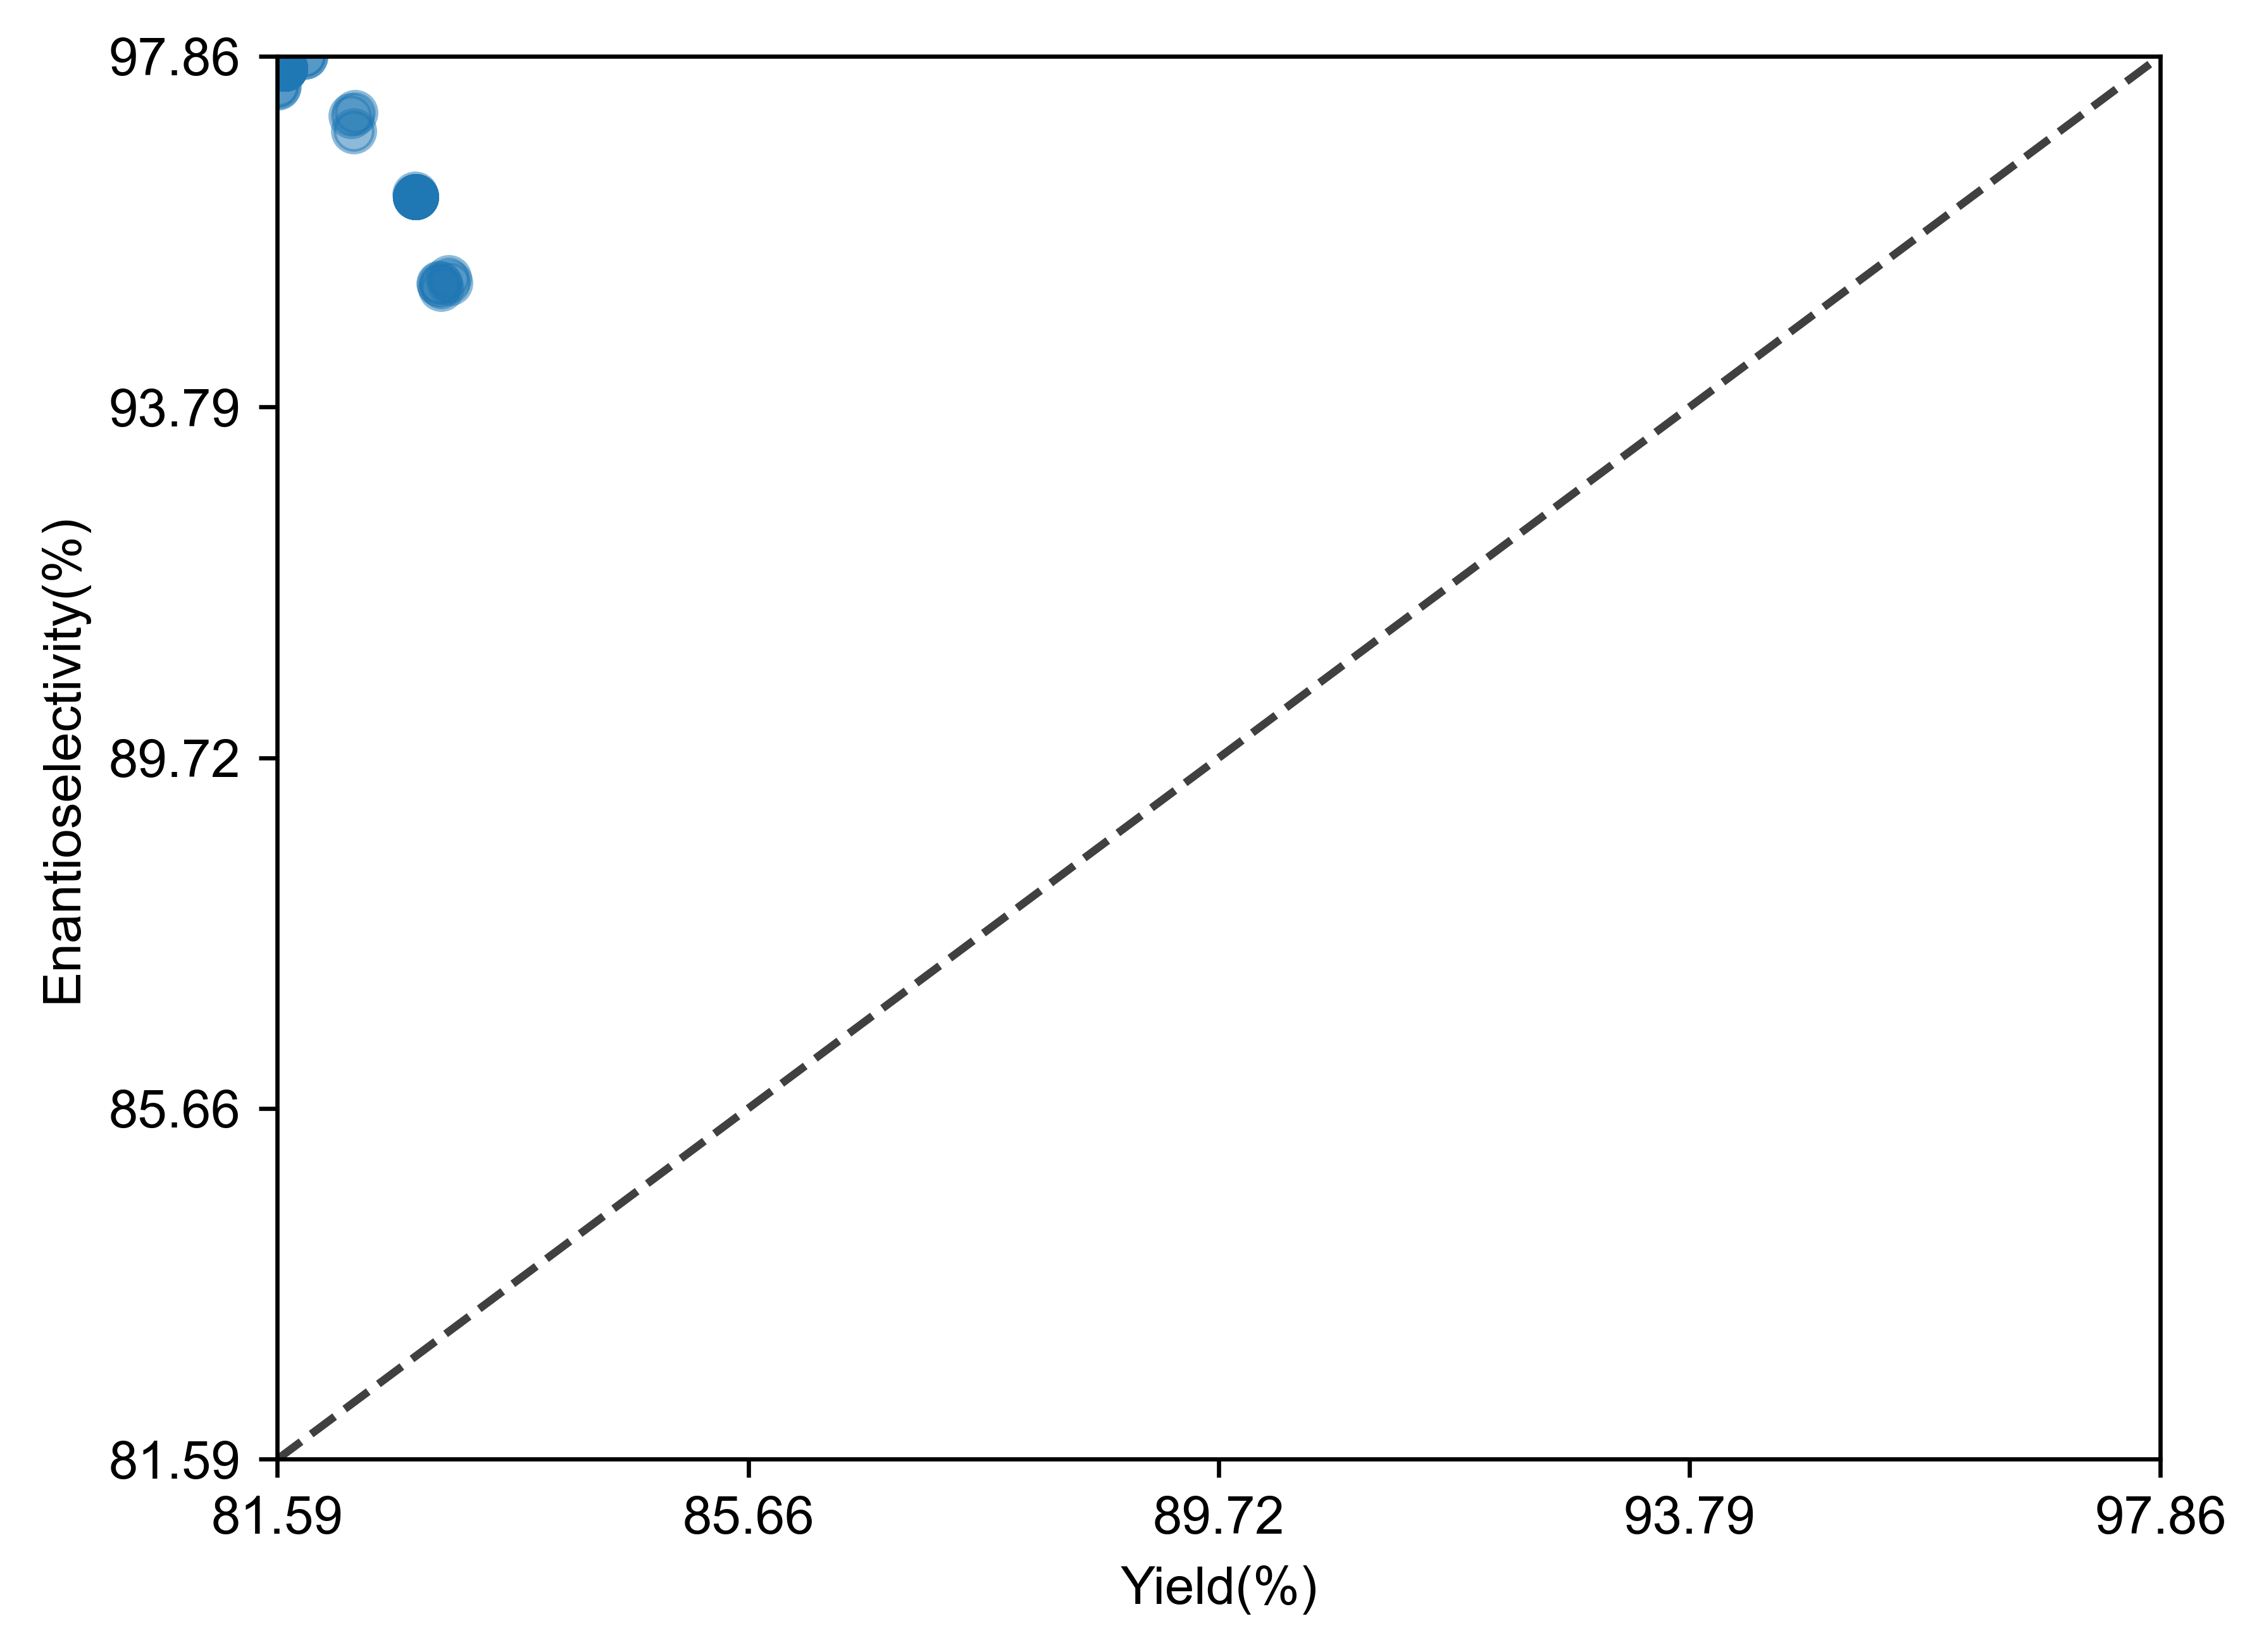

In [130]:
# %autoreload 2

display(data_opt.round(decimals=2))
data_opt.to_csv("../outputs/optimization.csv", index=False)
# Make the pareto plots
plotting.pareto_front_exp(Exp_lhc, fill=False, dpi=600)